In [151]:
import json
recipesNutrients = json.load(open("recipesNutrients2.txt"))

In [112]:
import unirest

def nutritions():
    response = unirest.get("https://spoonacular-recipe-food-nutrition-v1.p.mashape.com/recipes/541391/information?includeNutrition=true",
      headers={
        "X-Mashape-Key": "uI9T1GTt8nmshcUUWJOjq8TQNGBgp1P9Zffjsn7dAbkmTSDt1k",
        "Accept": "application/json"
      }
    )
    recipeInfo = response.body
    print(recipeInfo)
    #selectedNutritions = ['Calories', 'Fat', 'Saturated Fat', 'Sugar']
    recipeNutritions = recipeInfo['nutrition']['nutrients']
    nutritionsDict = {nutrition['title']: nutrition['amount'] for nutrition in recipeNutritions}# if nutrition['title'] in selectedNutritions}
    return nutritionsDict


nutritions = nutritions()
nutritions

{u'nutrition': {u'caloricBreakdown': {u'percentProtein': 7.15, u'percentCarbs': 8.31, u'percentFat': 84.54}, u'nutrients': [{u'amount': 354.6, u'percentOfDailyNeeds': 17.73, u'unit': u'cal', u'title': u'Calories'}, {u'amount': 35.72, u'percentOfDailyNeeds': 54.95, u'unit': u'g', u'title': u'Fat'}, {u'amount': 18.61, u'percentOfDailyNeeds': 116.31, u'unit': u'g', u'title': u'Saturated Fat'}, {u'amount': 7.9, u'percentOfDailyNeeds': 2.63, u'unit': u'g', u'title': u'Carbohydrates'}, {u'amount': 1.9, u'percentOfDailyNeeds': 2.11, u'unit': u'g', u'title': u'Sugar'}, {u'amount': 115.19, u'percentOfDailyNeeds': 38.4, u'unit': u'mg', u'title': u'Cholesterol'}, {u'amount': 247.17, u'percentOfDailyNeeds': 10.75, u'unit': u'mg', u'title': u'Sodium'}, {u'amount': 9.48, u'percentOfDailyNeeds': 3.16, u'unit': u'mg', u'title': u'Caffeine'}, {u'amount': 6.8, u'percentOfDailyNeeds': 13.6, u'unit': u'g', u'title': u'Protein'}, {u'amount': 0.43, u'percentOfDailyNeeds': 21.34, u'unit': u'mg', u'title': u'

{u'Caffeine': 9.48,
 u'Calcium': 79.11,
 u'Calories': 354.6,
 u'Carbohydrates': 7.9,
 u'Cholesterol': 115.19,
 u'Copper': 0.33,
 u'Fat': 35.72,
 u'Fiber': 2.44,
 u'Folate': 14.85,
 u'Iron': 1.91,
 u'Magnesium': 39.71,
 u'Manganese': 0.43,
 u'Phosphorus': 120.52,
 u'Potassium': 175.12,
 u'Protein': 6.8,
 u'Saturated Fat': 18.61,
 u'Selenium': 4.84,
 u'Sodium': 247.17,
 u'Sugar': 1.9,
 u'Vitamin A': 1028.38,
 u'Vitamin B1': 0.03,
 u'Vitamin B12': 0.22,
 u'Vitamin B2': 0.12,
 u'Vitamin B3': 0.24,
 u'Vitamin B5': 0.45,
 u'Vitamin B6': 0.05,
 u'Vitamin D': 0.66,
 u'Vitamin E': 0.6,
 u'Vitamin K': 3.01,
 u'Zinc': 1.15}

In [11]:
all_keys = list(set().union(*(d.keys() for d in recipesNutrients)))

In [194]:
nutrition_vector = [nutritions[nutrition] if nutrition in nutritions else 0 for nutrition in all_keys]

In [195]:
nutrition_vector = np.matrix(nutrition_vector)

In [152]:
all_nutritions = []
for nutritions in recipesNutrients: 
    vector = [nutritions[nut] if nut in nutritions else 0 for nut in all_keys]
    all_nutritions.append(vector)

In [155]:
len(all_nutritions)

88

(88L, 32L)
(2L, 32L) (3L, 32L)
0.994918448306
[[  2.53519074e-03]
 [  9.97452766e-01]
 [  1.20429725e-05]]
[1]


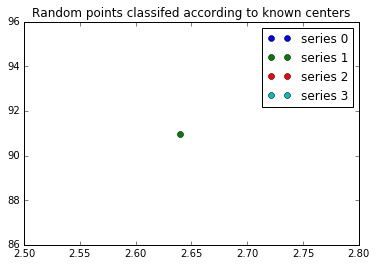

In [196]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

%matplotlib inline

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

nutrition_vectors = np.matrix(all_nutritions)

print(nutrition_vectors.shape)

# train the 100 examples
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(nutrition_vectors.T, 3, 1.5, error=0.005, maxiter=1000, init=None)
print(newtry.shape, cntr.shape)

# predict one example
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(nutrition_vector.T, cntr, 1.5, error=0.005, maxiter=1000)

print (fpc)
print(u)

cluster_membership = np.argmax(u, axis=0)  # Hardening for visualization

print(cluster_membership)

fig3, ax3 = plt.subplots()
ax3.set_title('Random points classifed according to known centers')
for j in range(4):
    ax3.plot(nutrition_vector[cluster_membership == j, 0],
             nutrition_vector[cluster_membership == j, 1], 'o',
             label='series ' + str(j))
ax3.legend()

plt.show()

In [179]:
# # Regenerate fuzzy model with 3 cluster centers - note that center ordering
# # is random in this clustering algorithm, so the centers may change places
# cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(
#     all_nutritions.T, 2, 2, error=0.005, maxiter=1000)

# # Show 3-cluster model
# fig2, ax2 = plt.subplots()
# ax2.set_title('Trained model')
# for j in range(3):
#     ax2.plot(all_nutritions.T[0, u_orig.argmax(axis=0) == j],
#              all_nutritions.T[1, u_orig.argmax(axis=0) == j], 'o',
#              label='series ' + str(j))
# ax2.legend()

In [108]:
# this is to make sense of what the u_orig.argmax does
print( u_orig.argmax(axis=0) == j)
print(all_nutritions.T[0])
print(all_nutritions.T[0, u_orig.argmax(axis=0) == j], j)
u_orig.argmax(axis = 0)

[False False False False False False False False False False False False
 False False False False False False False False]
[[ 0.    0.29  5.73  6.    0.89  0.43  4.5   1.69  0.94  5.01  1.16  2.51
   1.82  3.44  0.33  0.29  0.    0.42  3.83  9.02]]
[] 2


array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [216]:
import pandas as pd
experiments = []
m_list = [1.2, 1.5, 2, 2.5, 3]
for nclusters in range(2, 5):
    for m in m_list: 
        _, _, _, _, _, _, fpc = fuzz.cluster.cmeans(nutrition_vectors.T, nclusters, m, error=0.005, maxiter=1000, init=None)
        experiments.append((nclusters, m, fpc))
df = pd.DataFrame(experiments, columns=["cluster", "m-value", "fpc"])
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cluster,2.00000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000
m-value,1.20000,1.500000,2.000000,2.500000,3.000000,1.200000,1.500000,2.000000,2.500000,3.000000,1.200000,1.500000,2.000000,2.500000,3.000000
fpc,0.99811,0.985652,0.942819,0.875316,0.804163,0.964453,0.910918,0.798885,0.671438,0.571875,0.977702,0.920492,0.782946,0.513525,0.423432


In [218]:
df.to_latex()

u'\\begin{tabular}{lrrr}\n\\toprule\n{} &  cluster &  m-value &       fpc \\\\\n\\midrule\n0  &        2 &      1.2 &  0.998110 \\\\\n1  &        2 &      1.5 &  0.985652 \\\\\n2  &        2 &      2.0 &  0.942819 \\\\\n3  &        2 &      2.5 &  0.875316 \\\\\n4  &        2 &      3.0 &  0.804163 \\\\\n5  &        3 &      1.2 &  0.964453 \\\\\n6  &        3 &      1.5 &  0.910918 \\\\\n7  &        3 &      2.0 &  0.798885 \\\\\n8  &        3 &      2.5 &  0.671438 \\\\\n9  &        3 &      3.0 &  0.571875 \\\\\n10 &        4 &      1.2 &  0.977702 \\\\\n11 &        4 &      1.5 &  0.920492 \\\\\n12 &        4 &      2.0 &  0.782946 \\\\\n13 &        4 &      2.5 &  0.513525 \\\\\n14 &        4 &      3.0 &  0.423432 \\\\\n\\bottomrule\n\\end{tabular}\n'